<a href="https://colab.research.google.com/github/rtajeong/AI_Cluster_MSAC/blob/main/gg_136_RNN_%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%82%A0%EC%94%A8_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시계열 분석
- 온도, 습도, 기압, 풍향 등 14개 데이터 사용, 10분마다 기록
- 며칠간의 데이터를 입력하고 24시간 이후의 기온 예측

## 드롭아웃, 스태킹, 양방향 순환신경망 사용
- 순환 드롭아웃: 과대적합을 방지
- 스태킹 순환 층: 네트워크의 표현능력을 향상(계산량은 늘어난다)
- 양방향 순환 층: 서로 다른 방향으로 데이터를 입력하여 정확도를 높이고 기억을 오랫동안 유지  

## 데이터
- 독일 Jena시 막스 프랑크 생물지구화학연구소에서 지상 관측소에서 측정한 데이터
- 2009~2016년 데이터 사용

In [1]:
import numpy as np
import pandas as pd
import os, os.path, shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget --no-check-certificate \
    https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip \
    -O jena_climate.zip

--2025-11-25 07:07:43--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.124.136, 52.216.78.6, 16.182.33.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.124.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate.zip’

jena_climate.zip    100%[===================>]  12.94M  16.1MB/s    in 0.8s    

2025-11-25 07:07:45 (16.1 MB/s) - ‘jena_climate.zip’ saved [13565642/13565642]



In [3]:
!unzip jena_climate.zip

Archive:  jena_climate.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [4]:
!ls

jena_climate_2009_2016.csv  jena_climate.zip  __MACOSX	sample_data


In [ ]:
# 데이터프레임으로 읽는 경우
df = pd.read_csv('jena_climate_2009_2016.csv')
df[:3]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


In [ ]:
x = df.drop('Date Time', axis=1).values
x[:3]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02],
       [ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
         9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
         1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
         6.30000e-01,  1.71600e+02]])

In [ ]:
!head -10 jena_climate_2009_2016.csv

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,

In [5]:
# csv 파일을 직접 다루는 경우
f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print("데이터 사이즈: ",len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
데이터 사이즈:  420451


In [6]:
lines[:3]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']

In [7]:
lines[-3:]

['31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.20',
 '31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.80',
 '01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.90']

In [8]:
x = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    x[i, :] = values

In [9]:
x[:2]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02]])

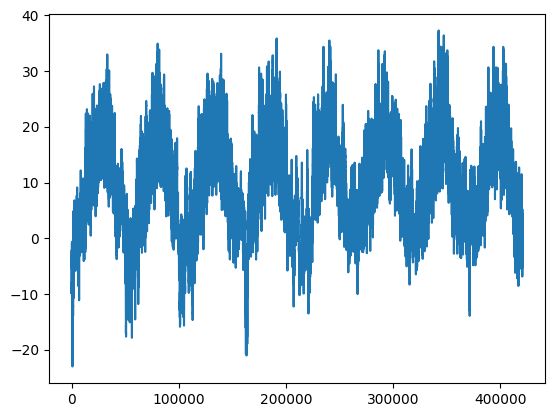

In [10]:
temp = x[:, 1]  # 기온만 그려본다 (T (degC))
plt.plot(range(len(temp)), temp)
plt.show()

### 10일간 데이터
- 샘플은 10분마다 측정
- 스케일링 필요 (데이터 속성이 다름)
- 하루에 140번 측정

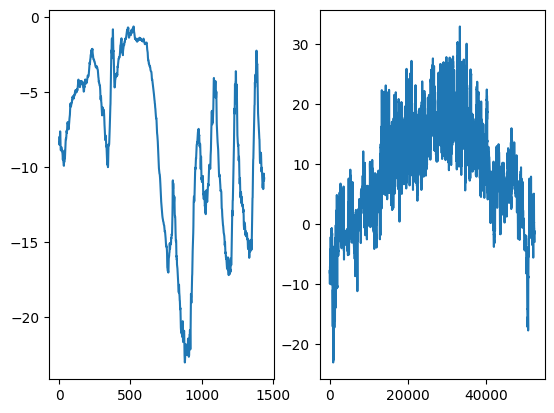

In [11]:
plt.subplot(1,2,1)
plt.plot(range(1440), temp[:1440])    # 10 days
plt.subplot(1,2,2)
plt.plot(range(52560), temp[:52560])  # 12 months ( 1 year)
plt.show()

## 파라미터 준비


* `lookback = 720`, 5일간 데이터를 관찰.
* `steps = 6`, 1시간마다 한번 샘플링.
* `delay = 144`, 24시간 후를 예측.

### 준비할 사항

- 데이터 변환 (스케일링): 20만개 훈련 샘플을 사용하여 평균과 표준편차를 계산한다.
- 데이터가 수치형이므로 벡터화는 사용하지 않는다
- 입력 데이터와 레이블을 공급하기 위한 제너레이터를 작성



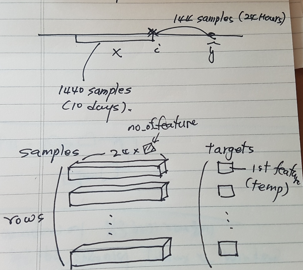

- input shape: batch_size x 240 (previous 10 days) x 14 (features)
- 위 그림 중 24 -> 240

In [ ]:
x.shape

(420451, 14)

In [ ]:
mean = x[:200000].mean(axis=0)
x -= mean
std = x[:200000].std(axis=0)
x /= std

In [ ]:
std, mean

(array([ 8.48043388,  8.85249908,  8.95324185,  7.16584991, 16.72731652,
         7.68914559,  4.19808168,  4.84034436,  2.66564926,  4.25206364,
        42.48884277,  1.53666449,  2.33067298, 86.61322998]),
 array([ 988.88635885,    9.07734895,  283.14631345,    4.44854725,
          75.35405895,   13.3829553 ,    9.29695535,    4.08591725,
           5.8752111 ,    9.40521005, 1217.51429655,    2.1510037 ,
           3.56950915,  176.21703355]))

제너레이터는 (samples, targets) 형태의 값을 생성한다.  sample은 입력의 한 배치를 나타낸다.

제너레이터를 사용하는 이유는 입력 데이터를 모두 한번에 메모리에 미리 로드하지 않기 위해서이다.

아래는 제너레이터 함수의 인자이다:

* `data`: 스케일링된 입력 데이터
* `lookback`: 과거의 몇개의 타임스텝을 사용할지 지정
* `delay`: 미래 몇 타임스텝후를 예측할지
* `min_index` and `max_index`: 검증 및 테스트 데이터를 구분하는 경계를 표시
* `shuffle`: 샘플들은 랜덤하게 취할지를 지정
* `batch_size`: 배치 크기
* `step`: 샘플 데이터를 취할 타임스텝수 (여기서는 6)

In [12]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))  # (128, 240//6, 14)
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

훈련 데이터는 처음 20만개, 검증 데이터는 다음 10만개, 나머지는 테스트 데이터로 사용한다.
SGD를 사용하면 과적합을 피하고, 최적값을 찾아낸 확률이 높아진다.

In [13]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(x,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(x,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(x,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(x) - 300001 - lookback) // batch_size

In [14]:
next(train_gen)[0].shape   # sample (batch_size, lookback 갯수, feature dim)

(128, 240, 14)

In [15]:
next(train_gen)[1].shape   # target (144 sample (하루) 뒤의 T 값)

(128,)

## 기본 성능 모델 (Base Model)

평균치 예측 등, 가장 기본적인 성능을 내는, 최소 기준의 모델을 말한다. 기계학습을 사용하면 적어도 이보다는 성능이 좋아야 한다.
  
여기서는 내일의 날씨는 오늘과 같다고 단순히 예측하는 모델을 사용하겠다. 성능 평가로 절대값 오차를 사용(MAE).

- 아래에 기본 성능 모델의 성능을 계산하였다.

In [16]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]         # 현재의 온도로 예측
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

2.564887434980494


오차 값 0.29는 정규화 한 값이므로 표준 편차(8.8525)를 곱하여 온도의 오차를 구할 수 있다. 온도의 평균 오차는  
2.57˚C이다.

## 간단한 신경망 모델
- 여기서는 두개의 전결합망으로 구성된 MLP을 먼저 만들어보겠다. 성능평가는 MAE를 사용한다.회귀문제이므로 마지막 단은 활성화함수를 사용하지 않는다.

In [17]:
batch_size, lookback // step, x.shape[-1]

(128, 240, 14)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, x.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 69.2832 - val_loss: 10.0631
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 10.2057 - val_loss: 9.7261
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 10.0991 - val_loss: 9.4087
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 9.5584 - val_loss: 9.1003
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 9.2328 - val_loss: 8.8142
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 9.0864 - val_loss: 8.5478
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 8.8358 - val_loss: 8.2989
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 8.5345 - val_loss: 8.0673
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 8.3972 - val_loss: 7.8536
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 8.1412 - val_loss: 7.6556
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 7.9049 - val_loss: 7.4774
Epoch 12/20
500/500 ━━━━━━

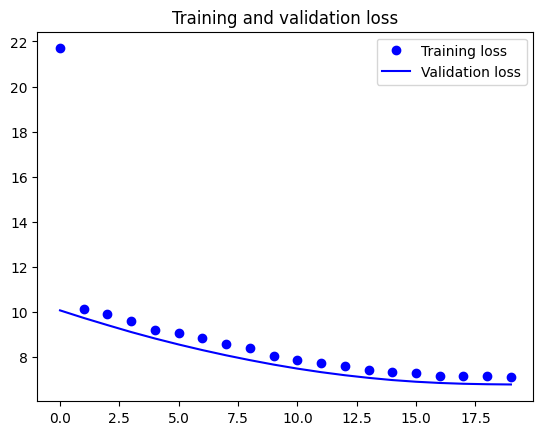

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 앞에서 구한 기본성능 0.29을 얻는 것도 쉽지 않다. 모델로 복잡한 구조를 사용했다고 해서 간단한, 상식적인 모델보다 우수한 성능을 내는 것은 아니다. 모델이 이러한 답을 바로 찾을 수 있다는 보장은 없다. (사람의 직관에 의한 기본 성능을 내는 것도 컴퓨터에게는 어려울 수 있다.)

## 간단한 RNN 모델
- 앞의 MLP는 시간 정보를 활용하지 못하고 있다. 시퀀스 데이터를 그대로 사용하고 이를 반영하는 모델을 만들어야 한다.

LSTM을 간략히 구현하는 방식인 GRU(gated recurrent unit)을 사용하겠다.

In [22]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 9.6358 - val_loss: 6.2250
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 6.0172 - val_loss: 4.8636
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 5.0156 - val_loss: 4.3267
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 4.4556 - val_loss: 3.8166
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 4.0720 - val_loss: 3.5110
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 3.8443 - val_loss: 3.3864
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 3.7261 - val_loss: 3.3588
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 3.6450 - val_loss: 3.1903
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 3.5958 - val_loss: 3.6597
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 3.5501 - val_loss: 3.3115
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 3.5716 - val_loss: 3.6162
Epoch 12/20
500/500 ━━━━━━━━━━

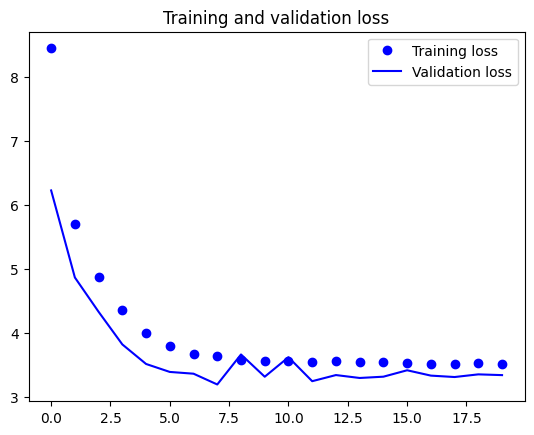

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- MAE 성능이 0.265 (과대 적합하기 시작하는 곳) 정도로 조금 개선되었다.(2.35˚C) - 기본 모델의 성능이 2.57˚C 였다.

## 과대적합 줄이기
- 몇 번의 이포크 후에 성능이 나빠지므로 과대적합된 것을 알 수 있다. 오랫동안 순환층 이전에 드롭아웃을 사용하면 학습에 방해가 된다고 알려져 왔다.
- 순환네트워크에 드롭아웃을 적절하게 사용하기 위해서는 타임 스텝마다 랜덤하게 드롭아웃 패턴을 바꾸지 않고, 동일한 패턴을 모든 타임 스텝에 적용해야 한다.
- 드롭아웃으로 규제된 네트워크는 완전히 수렴하는데 학습시간이 더 오래 걸린다.
- recurrent dropout: it drops out the input/update gate in LSTM/GRU. (recurrent state)
-  In Keras dropout can be applied either on inputs (dropout), which should be straightforward, or on previous hidden state (recurrent_dropout)

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     #recurrent_dropout=0.2,   # not supported by cuDNN, so it will be slow)
                     input_shape=(None, x.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


<ipython-input-30-b104d456c649>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 21s 37ms/step - loss: 0.3244 - val_loss: 0.2749
Epoch 2/40
500/500 [==============================] - 15s 31ms/step - loss: 0.3041 - val_loss: 0.2733
Epoch 3/40
500/500 [==============================] - 14s 29ms/step - loss: 0.2980 - val_loss: 0.2750
Epoch 4/40
500/500 [==============================] - 14s 29ms/step - loss: 0.2921 - val_loss: 0.2802
Epoch 5/40
500/500 [==============================] - 14s 29ms/step - loss: 0.2881 - val_loss: 0.2692
Epoch 6/40
500/500 [==============================] - 15s 29ms/step - loss: 0.2824 - val_loss: 0.2732
Epoch 7/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2780 - val_loss: 0.2737
Epoch 8/40
500/500 [==============================] - 15s 29ms/step - loss: 0.2727 - val_loss: 0.2714
Epoch 9/40
500/500 [==============================] - 14s 29ms/step - loss: 0.2692 - val_loss: 0.2707
Epoch 10/40
500/500 [==============================] - 14s 29ms/step - loss: 0.2659 - val_los

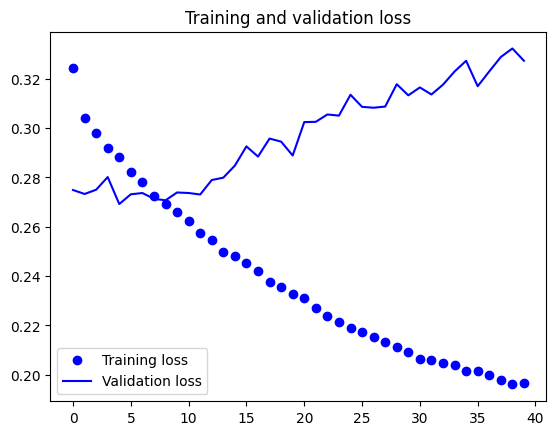

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 순환망 쌓기 (Stacking)
- 이제 과대적합이 되기 전까지는 네트워크의 복잡도(용량)을 늘려서 성능을 개선할 수 있다. 스태킹을 하려면 중간 계층에서는 시퀀스 전체를 출력해야 한다. 이를 위해서 return_sequences=True 로 설정해야 한다.

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, x.shape[-1])))

# model.add(layers.GRU(64, activation='relu',
model.add(layers.GRU(64, activation='tanh',    # relu -> not supported by cuDNN
                     dropout=0.1,
                     # recurrent_dropout=0.5
                     ))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


<ipython-input-32-5b20d8848022>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 438s 866ms/step - loss: 0.3212 - val_loss: 0.2786
Epoch 2/40
500/500 [==============================] - 435s 870ms/step - loss: 0.3047 - val_loss: 0.2805
Epoch 3/40
386/500 [======================>.......] - ETA: 1:25 - loss: 0.2949

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Exercise

In [ ]:
def my_gen():      # define a generator (it generates an iterator object.)
    x = np.arange(5)
    for i,j in enumerate(x):
        yield j
gen = my_gen()

In [ ]:
type(gen)

generator

In [ ]:
next(gen), next(gen), next(gen)

(0, 1, 2)

In [ ]:
for i in gen:
    print(i)

3
4
